Link para geração dos mosaicos:
https://colab.research.google.com/drive/1C-ut9LLjuYH0hVXgvJK0kdD_i69AIpkJ?usp=sharing no colab



# Mount Google Drive

After adding the shortcut to the data in your Google Drive, the next step is to mount a Google Drive volume on Google Colab.

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True) 

Mounted at /content/drive


# Check GPU

We recommend that the entire model and classification training process be done using some of the GPUs available from Google Colab.

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Mon Apr  5 13:11:54 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.67       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Install Requirements

In [ ]:
#Step 1
!apt-get update
#Step 2
!apt-get install libgdal-dev -y
#Step 3
!apt-get install python-gdal -y

# Imports

In [ ]:
import os
from os import listdir
from os.path import isfile, join, sep, exists
import gc
import random
import cv2


import h5py
import numpy as np
from osgeo import gdal, osr
from skimage.transform import resize, rotate
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from tqdm import tqdm
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D, Dropout, MaxPooling2D, \
    Conv2DTranspose, concatenate, BatchNormalization, Activation
from tensorflow.keras.losses import binary_crossentropy
from matplotlib import pyplot as plt
from sklearn.utils import compute_class_weight
from skimage import exposure

# Settings

> Important:
Create a folder to train follow the structure:
1. TRAIN_LANDSAT_ARROZ\
    1.1 rice_train\
    1.2 rice_logs\
    1.3 predict\
    1.4 rice_predicted


In [ ]:
CHIP_SIZE = 256
CHANNELS = 4
LABELS = [0, 1]
SPATIAL_SCALE = 30
PROJECTION = 3857 # pseudo-mercator
REPROJECT = False

# Build Datasets
GRIDS = 1
ROTATE = True
FLIP = False
TRAIN_VALIDATION_DIR = ["/content/drive/MyDrive/TRAIN_LANDSAT_ARROZ/rice_train"]
TRAIN_PATH = "/content/train.h5"
VALIDATION_PATH = "/content/validation.h5"
TEST_PATH = "/content/test.h5"
COMPRESSION= 'gzip' # 'gzip' or None

# Train model
#TRAIN_BATCH_SIZE = 16 # para  16
TRAIN_BATCH_SIZE = 5 # para 64
TRAIN_EPOCHS = 100
MODEL_DIR = "/content/drive/MyDrive/TRAIN_LANDSAT_ARROZ/rice_logs"

# Predict images
PREDICT_INPUT_DIR = "/content/drive/MyDrive/TRAIN_LANDSAT_ARROZ/predict"
PREDICT_OUPUT_DIR = "/content/drive/MyDrive/TRAIN_LANDSAT_ARROZ/predicted"
PREDICT_CHIP_SIZE = 256
PREDICT_GRIDS = 1
PREDICT_BATCH_SIZE = 1

os.makedirs(MODEL_DIR, exist_ok=True)
os.makedirs(PREDICT_OUPUT_DIR, exist_ok=True)




# Image Utils

In [ ]:
def load_file(path):
    original_source = gdal.Open(path)

    if REPROJECT:
        new_source = reproject_dataset(original_source,
                                    pixel_spacing=SPATIAL_SCALE,
                                    epsg_to=PROJECTION)
    else:
        new_source = original_source

    if not new_source is None:
        bands = []
        for index in range(1, new_source.RasterCount + 1):
            band = new_source.GetRasterBand(index).ReadAsArray()
            bands.append(band)

        image = np.dstack(bands)

        return original_source, new_source, image
    else:
        return original_source, new_source, None

def normalize(image):
    # image_mean = np.nanmean(image)
    # image_std = np.nanstd(image)
    # normalized = np.array( (image - image_mean) / image_std )
    normalized = image / 255
    return normalized


def get_rotate(image):
    images = []
    for rot in [90, 180, 270]:
        image_rotate = rotate(image, rot, preserve_range=True)
        images.append(image_rotate)
    return images

def get_flip(image):
    horizontal_flip = image[:, ::-1]
    vertical_flip = image[::-1, :]
    return [horizontal_flip, vertical_flip]

def make_dataset(filename, width, height, channels):
    dataset = h5py.File(filename, 'w')

    x_data = dataset.create_dataset("x", 
                                    (0, width, height, channels), 
                                    maxshape=(None, width, height, channels),
                                    chunks=True, 
                                    compression=COMPRESSION)
    
    y_data = dataset.create_dataset("y", 
                                    (0, width, height, 1), 
                                    maxshape=(None, width, height, 1),
                                    chunks=True, 
                                    compression=COMPRESSION)
    
    return dataset, x_data, y_data

def save_dataset(X, y, output_path, chip_size, channels):
    if os.path.isfile(output_path):
        dataset, x_data, y_data = load_dataset(output_path)
    else:
        dataset, x_data, y_data = make_dataset(output_path, 
                                               chip_size,
                                               chip_size, 
                                               channels)

    length = len(X)

    x_data_size = x_data.len()
    y_data_size = y_data.len()

    x_data.resize((x_data_size + length, chip_size, chip_size, channels))
    y_data.resize((y_data_size + length, chip_size, chip_size, 1))

    print("Saving dataset..." , len(X))
    
    x_data[y_data_size:] = X
    y_data[y_data_size:] = y

    dataset.close()

def load_dataset(dataset, read_only=False):
    if read_only:
        dataset = h5py.File(dataset, 'r')
    else:
        dataset = h5py.File(dataset, 'r+')
    
    x_data = dataset["x"]
    y_data = dataset["y"]

    return dataset, x_data, y_data


def mosaic_is_empty(image):
    empty_percentage = (np.sum(np.sum(image == 0, axis=2) == CHANNELS) / (image.shape[0] * image.shape[1])) * 100
    return empty_percentage >= 5


def chip_is_empty(chip):
    unique_labels = np.unique(chip)
    return 0 in unique_labels and len(unique_labels) == 1


def generate_dataset(image_path, labels_path, chip_size, channels, 
                     grids=1, allow_empty_chip=False, rotate=False, flip=False):
    _, _, image_data = load_file(image_path)
    _, _, image_labels = load_file(labels_path)

    image_labels = resize(image_labels,
                          (image_data.shape[0], image_data.shape[1]),
                          preserve_range=True, anti_aliasing=True).astype(np.int8)

    image = np.dstack([image_data, image_labels])

    X_set = []
    y_set = []

    for step in get_grids(grids, chip_size):
        for (x, y, window, dimension) in sliding_window(image,
                                                        step["steps"],
                                                        step["chip_size"],
                                                        (chip_size,
                                                         chip_size)):

            train = np.array(window[:, :, : channels])

            labels = np.array(window[:, :, -1:], dtype=np.int8)

            unique_labels = np.unique(labels)
            
            if (chip_is_empty(labels) or mosaic_is_empty(train)) and not allow_empty_chip:
                continue

            # if mosaic_is_empty(train) and not allow_empty_chip or set(unique_labels) != set(LABELS):
            #     continue

            raw_image = np.dstack([train, labels])
            images_daugmentation = [raw_image]
            
            if rotate:
                images_rotate = get_rotate(raw_image)
                images_daugmentation.extend(images_rotate)

            if flip:
                images_flip = []
                for im in images_daugmentation:
                    images_flip.extend(get_flip(im))
                images_daugmentation.extend(images_flip)

            X_group = []
            Y_group = []

            for i in images_daugmentation:
                new_train = np.array(i[:, :, :channels])
                new_labels = np.array(i[:, :, -1:], dtype=np.int8)

                np.clip(new_labels, 0, None, out=new_labels)
                
                X_group.append(new_train)
                Y_group.append(new_labels)

            X_set.append(X_group)
            y_set.append(Y_group)

        X_set = np.array(X_set)
        y_set = np.array(y_set)

        yield X_set, y_set


def generate_train_validation_dataset(image_path, labels_path, 
                                      train_path, validation_path, test_path, 
                                      chip_size, 
                                      channels=1, 
                                      grids=1, 
                                      allow_empty_chip=False, 
                                      rotate=False, flip=False):
    
    for X_set, y_set in generate_dataset(image_path, labels_path, 
                                    chip_size=chip_size,
                                    channels=channels, 
                                    grids=grids, 
                                    allow_empty_chip=allow_empty_chip, 
                                    rotate=rotate, 
                                    flip=flip):
        
        if len(X_set) >= 5:
            X_train, X_val, y_train, y_val = train_test_split(X_set, y_set,
                                                        test_size=0.30,
                                                        random_state=1)
            
            X_val, X_test, y_val, y_test = train_test_split(X_val, y_val,
                                                        test_size=0.30,
                                                        random_state=1)

            X_train =  np.array([item for sublist in X_train for item in sublist])
            y_train =  np.array([item for sublist in y_train for item in sublist])

            X_val =  np.array([item for sublist in X_val for item in sublist])
            y_val =  np.array([item for sublist in y_val for item in sublist])

            X_test =  np.array([item for sublist in X_test for item in sublist])
            y_test =  np.array([item for sublist in y_test for item in sublist])

            save_dataset(X_train, y_train, train_path, chip_size, channels)
            save_dataset(X_val, y_val, validation_path, chip_size, channels)
            save_dataset(X_test, y_test, test_path, chip_size, channels)

def sliding_window(image, step, chip_size, chip_resize):
    # slide a chip across the image
    step_cols = int(step[0])
    step_rows = int(step[1])

    cols = image.shape[1]
    rows = image.shape[0]

    chip_size_cols = chip_size[0]
    chip_size_rows = chip_size[1]

    chip_resize_cols = chip_resize[0]
    chip_resize_rows = chip_resize[1]

    for y in range(0, rows, step_rows):
        for x in range(0, cols, step_cols):

            origin_x = x
            origin_y = y

            if (origin_y + chip_size_rows) > rows:
                origin_y = rows - chip_size_rows

            if (origin_x + chip_size_cols) > cols:
                origin_x = cols - chip_size_cols

            chip = image[origin_y:origin_y + chip_size_rows,
                   origin_x: origin_x + chip_size_cols]

            original_shape = chip.shape

            if chip.shape != (chip_resize_cols, chip_resize_rows):
                chip = resize(chip,
                              (chip_resize_cols, chip_resize_rows),
                              preserve_range=True,
                              anti_aliasing=True)

            yield (origin_x, origin_y, chip, original_shape)


def get_window(matrix, x, y, width, height):
    return matrix[y:y + height, x:x + width]


def set_window(matrix, x, y, new_matrix):
    for i_index, i in enumerate(range(y, y + new_matrix.shape[0])):
        for j_index, j in enumerate(range(x, x + new_matrix.shape[1])):
            matrix[i][j] = new_matrix[i_index][j_index]


def transform_labels(labels_array, labels):
    lb = preprocessing.LabelBinarizer()
    lb.fit(labels)
    new_labels_array = []
    for ix, l in enumerate(labels_array):
        flat_labels = l.reshape((l.shape[0] * l.shape[1],))
        transformed_flat_labels = lb.transform(flat_labels)
        new_labels_array.append(transformed_flat_labels.reshape(
            (l.shape[0], l.shape[1], len(labels))))

    new_labels_array = np.array(new_labels_array)
    return new_labels_array


def get_grids(grids, chip_size):
    grids_dict = {
        1: [
            {"steps": (chip_size, chip_size),
             "chip_size": (chip_size, chip_size)}
        ],
        2: [
            {"steps": (int(chip_size * 0.5), int(chip_size * 0.5)),
             "chip_size": (chip_size, chip_size)},
        ],
        3: [
            {"steps": (int(chip_size * 0.9), int(chip_size * 0.9)),
             "chip_size": (chip_size, chip_size)},
        ]
    }

    return grids_dict[grids]


def reproject_dataset(g, pixel_spacing=30., epsg_to=3857):
    osng = osr.SpatialReference()
    osng.ImportFromEPSG(epsg_to)

    wkt = g.GetProjection()
    wgs84 = osr.SpatialReference()
    wgs84.ImportFromWkt(wkt)

    tx = osr.CoordinateTransformation(wgs84, osng)
    # Up to here, all  the projection have been defined, as well as a
    # transformation from the from to the  to :)

    # Get the Geotransform vector
    geo_t = g.GetGeoTransform()
    x_size = g.RasterXSize  # Raster xsize
    y_size = g.RasterYSize  # Raster ysize
    # Work out the boundaries of the new dataset in the target projection
    (ulx, uly, ulz) = tx.TransformPoint(geo_t[0], geo_t[3])
    (lrx, lry, lrz) = tx.TransformPoint(geo_t[0] + geo_t[1] * x_size, \
                                        geo_t[3] + geo_t[5] * y_size)

    # Now, we create an in-memory raster
    mem_drv = gdal.GetDriverByName('MEM')
    # The size of the raster is given the new projection and pixel spacing
    # Using the values we calculated above. Also, setting it to store one band
    # and to use Float32 data type.
    dest = mem_drv.Create('', int((lrx - ulx) / pixel_spacing), \
                          int((uly - lry) / pixel_spacing), g.RasterCount,
                          g.GetRasterBand(1).DataType)
    # Calculate the new geotransform
    new_geo = (ulx, pixel_spacing, geo_t[2], \
               uly, geo_t[4], -pixel_spacing)
    # Set the geotransform
    dest.SetGeoTransform(new_geo)
    dest.SetProjection(osng.ExportToWkt())
    # Perform the projection/resampling
    res = gdal.ReprojectImage(g, dest, \
                              wgs84.ExportToWkt(), osng.ExportToWkt(), \
                              gdal.GRA_NearestNeighbour)
    return dest



def save_results(original_dataset, reprojected_dataset, image, output_path):
    mem_dataset = reprojected_dataset \
        .GetDriver() \
        .Create(output_path, image.shape[1], image.shape[0], 1, gdal.GDT_Int16)

    mem_dataset.SetGeoTransform(reprojected_dataset.GetGeoTransform())
    mem_dataset.SetProjection(reprojected_dataset.GetProjection())
    mem_dataset.GetRasterBand(1) \
        .WriteArray(image.reshape((image.shape[0], image.shape[1])), 0, 0)
    mem_dataset.FlushCache()

    original_epsg = int(osr \
                        .SpatialReference(wkt=original_dataset.GetProjection()) \
                        .GetAttrValue('AUTHORITY', 1))

    output_dataset = reproject_dataset(mem_dataset,
                                       SPATIAL_SCALE,
                                       original_epsg)

    original_dataset.GetDriver().CreateCopy(output_path,
                                            output_dataset,
                                            options=['COMPRESS=LZW',
                                                     'TFW=YES'])

# Build Datasets

## Build Train, Validation and Test datasets

In [ ]:
import glob

for path in TRAIN_VALIDATION_DIR:

    images = [f for f in glob.glob(path + "/*mosaic.tif", recursive=True)]

    if len(images) == 0:
        print("No samples found.")

    for image_path in images:
        labels_path = image_path.replace("mosaic", "labels")
        print(image_path)
        print(labels_path)
        generate_train_validation_dataset(
            image_path=image_path,
            labels_path=labels_path,
            train_path=TRAIN_PATH,
            validation_path=VALIDATION_PATH,
            test_path=TEST_PATH,
            chip_size=CHIP_SIZE,
            channels=CHANNELS,
            grids=GRIDS,
            rotate=ROTATE
        )

/content/drive/MyDrive/TRAIN_LANDSAT_ARROZ/rice_train_v5/id_145_mosaic.tif
/content/drive/MyDrive/TRAIN_LANDSAT_ARROZ/rice_train_v5/id_145_labels.tif
Saving dataset... 200
Saving dataset... 60
Saving dataset... 28
/content/drive/MyDrive/TRAIN_LANDSAT_ARROZ/rice_train_v5/id_195_mosaic.tif
/content/drive/MyDrive/TRAIN_LANDSAT_ARROZ/rice_train_v5/id_195_labels.tif
Saving dataset... 136
Saving dataset... 40
Saving dataset... 20
/content/drive/MyDrive/TRAIN_LANDSAT_ARROZ/rice_train_v5/id_94_mosaic.tif
/content/drive/MyDrive/TRAIN_LANDSAT_ARROZ/rice_train_v5/id_94_labels.tif
Saving dataset... 184
Saving dataset... 56
Saving dataset... 24
/content/drive/MyDrive/TRAIN_LANDSAT_ARROZ/rice_train_v5/id_194_mosaic.tif
/content/drive/MyDrive/TRAIN_LANDSAT_ARROZ/rice_train_v5/id_194_labels.tif
Saving dataset... 176
Saving dataset... 52
Saving dataset... 24
/content/drive/MyDrive/TRAIN_LANDSAT_ARROZ/rice_train_v5/id_197_mosaic.tif
/content/drive/MyDrive/TRAIN_LANDSAT_ARROZ/rice_train_v5/id_197_labels.

## Plot Images

1124
2482
201
2836
Labels:  [0. 1.]
Labels:  [0. 1.]
Labels:  [0. 1.]
Labels:  [0. 1.]


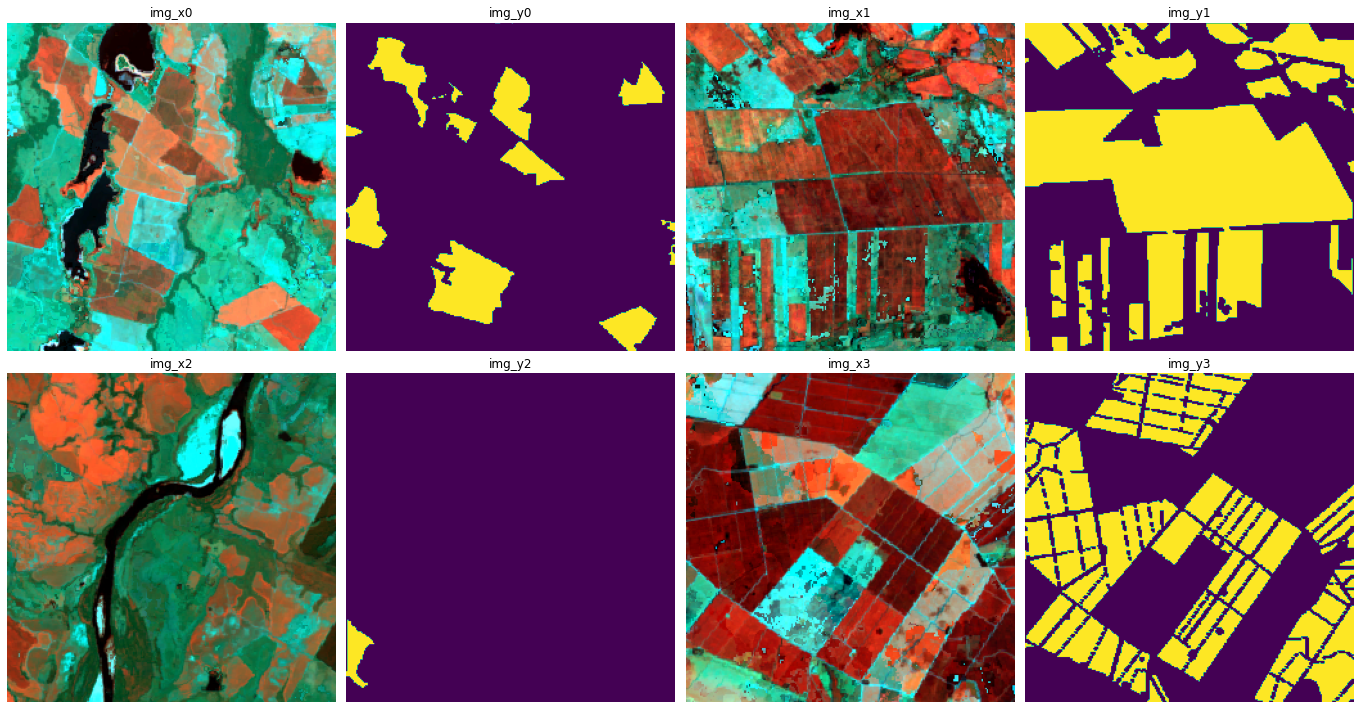

In [ ]:
def plot_figures(figures, nrows = 1, ncols=1):
    """Plot a dictionary of figures.

    Parameters
    ----------
    figures : <title, figure> dictionary
    ncols : number of columns of subplots wanted in the display
    nrows : number of rows of subplots wanted in the figure
    """

    fig, axeslist = plt.subplots(ncols=ncols, nrows=nrows, figsize=(19, 10))
    for ind,title in zip(range(len(figures)), figures):
        image = figures[title]
        if image.shape[2] >= 3:
            image = image[:, : , :3]
            for i in range(3):
                band = image[:,:,i]
                in_low, in_high = np.percentile(band, (2, 98))
                band = exposure.rescale_intensity(band, in_range=(in_low, in_high))
                image[:,:,i] = band
            axeslist.ravel()[ind].imshow(image)
        else:
            image = image.reshape((image.shape[0], image.shape[1]))
            print("Labels: ", np.unique(image))
            axeslist.ravel()[ind].imshow(image, vmin=LABELS[0], vmax=LABELS[-1])

        axeslist.ravel()[ind].set_title(title)
        axeslist.ravel()[ind].set_axis_off()
    plt.tight_layout() # optional

figures = {}

dataset, x, y = load_dataset(TRAIN_PATH, read_only=True)

ids = []

samples = 4

for i in range(0, samples):
    id = random.randint(0,x.shape[0]-1)
    print(id)
    figures['img_x'+ str(i)] = x[id]
    figures['img_y'+ str(i)] = y[id]

plot_figures(figures, 2, samples)
dataset.close()

## Calculate classes proportion

In [ ]:
dataset, x, y = load_dataset(VALIDATION_PATH, read_only=True)

print("Shapes:", x.shape, y.shape)

y_values = np.array(y).reshape(y.shape[0] * y.shape[1] * y.shape[2])

unique, counts = np.unique(y_values, return_counts=True)
labels_count = dict(zip(unique, counts))

total = sum(labels_count.values())

for label_value in LABELS:
    print("Label: {} Proportion: {}".format(label_value, labels_count.get(label_value) / total))

dataset.close()

Shapes: (1076, 256, 256, 4) (1076, 256, 256, 1)
Label: 0 Proportion: 0.9098794930043274
Label: 1 Proportion: 0.09012050699567263


## Calculte classe weights

In [ ]:
weights = compute_class_weight('balanced', LABELS, y_values)
class_weights = dict(zip(LABELS, weights))
class_weights

{0: 0.5495233202245849, 1: 5.548126798976051}

# Model

## Define losses

In [ ]:
def categorical_focal_loss(gamma=2., alpha=.25):
    """
    Softmax version of focal loss.

           m
      FL = ∑  -alpha * (1 - p_o,c)^gamma * y_o,c * log(p_o,c)
          c=1

      where m = number of classes, c = class and o = observation

    Parameters:
      alpha -- the same as weighing factor in balanced cross entropy
      gamma -- focusing parameter for modulating factor (1-p)

    Default value:
      gamma -- 2.0 as mentioned in the paper
      alpha -- 0.25 as mentioned in the paper

    References:
        Official paper: https://arxiv.org/pdf/1708.02002.pdf
        https://www.tensorflow.org/api_docs/python/tf/keras/backend/categorical_crossentropy

    Usage:
     model.compile(loss=[categorical_focal_loss(alpha=.25, gamma=2)], metrics=["accuracy"], optimizer=adam)
    """
    def categorical_focal_loss_fixed(y_true, y_pred):
        """
        :param y_true: A tensor of the same shape as `y_pred`
        :param y_pred: A tensor resulting from a softmax
        :return: Output tensor.
        """

        y_true = K.cast(y_true, "float32")
        y_pred = K.cast(y_pred, "float32")

        # Scale predictions so that the class probas of each sample sum to 1
        y_pred /= K.sum(y_pred, axis=-1, keepdims=True)

        # Clip the prediction value to prevent NaN's and Inf's
        epsilon = K.epsilon()
        y_pred = K.clip(y_pred, epsilon, 1. - epsilon)

        # Calculate Cross Entropy
        cross_entropy = -y_true * K.log(y_pred)

        # Calculate Focal Loss
        loss = alpha * K.pow(1 - y_pred, gamma) * cross_entropy

        # Sum the losses in mini_batch
        return K.sum(loss, axis=1)

    return categorical_focal_loss_fixed

## Define metrics

In [ ]:
def jaccard_coef(y_true, y_pred):
    smooth = 1e-12
    intersection = K.sum(y_true * y_pred, axis=[0, -1, -2])
    sum_ = K.sum(y_true + y_pred, axis=[0, -1, -2])
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return K.mean(jac)

def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

## U-Net

In [ ]:
def conv2d_block(n_filters, kernel_size, activation='relu', inputs=None):
    net = Conv2D(filters=n_filters, 
                 kernel_size=kernel_size, 
                 activation=None,
                 kernel_initializer='he_normal',
                 padding='same') (inputs) 
    net = BatchNormalization()(net)
    net = Activation(activation)(net)

    net = Conv2D(filters=n_filters, 
                 kernel_size=kernel_size, 
                 activation=None,
                 kernel_initializer='he_normal', 
                 padding='same') (net) 
    net = BatchNormalization()(net)
    net = Activation(activation)(net)

    return net

def transpose(n_filters, kernel_size, inputs=None):
    net = Conv2DTranspose(n_filters, 
                          kernel_size, 
                          strides=(2, 2),
                          padding='same') (inputs)
    return net

def model_fn(input_shape, n_filters=16, dropout = 0.5, labels=[]): # parâmetro n_filters
    inputs = keras.Input(input_shape)

    c1 = conv2d_block(n_filters * 1, (3, 3), inputs=inputs)
    p1 = MaxPooling2D((2, 2)) (c1)

    c2 = conv2d_block(n_filters * 2, (3, 3), inputs=p1)
    p2 = MaxPooling2D((2, 2)) (c2)

    c3 = conv2d_block(n_filters * 4, (3, 3), inputs=p2)
    p3 = MaxPooling2D((2, 2)) (c3)

    c4 = conv2d_block(n_filters * 8, (3, 3), inputs=p3)
    c4 = Dropout(dropout) (c4)
    p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

    c5 = conv2d_block(n_filters * 16, (3, 3), inputs=p4)
    c5 = Dropout(dropout) (c5)

    u6 = transpose(n_filters * 8, (2, 2), inputs=c5)
    u6 = concatenate([u6, c4])
    c6 = conv2d_block(n_filters * 8, (2, 2), inputs=u6)
    
    u7 = transpose(n_filters * 4, (2, 2), inputs=c6)
    u7 = concatenate([u7, c3])
    c7 = conv2d_block(n_filters * 4, (2, 2), inputs=u7)

    u8 = transpose(n_filters * 2, (2, 2), inputs=c7)
    u8 = concatenate([u8, c2])
    c8 = conv2d_block(n_filters * 2, (2, 2), inputs=u8)
    
    u9 = transpose(n_filters * 1, (2, 2), inputs=c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = conv2d_block(n_filters * 1, (2, 2), inputs=u9)
    
    if len(labels) > 2:
        outputs = tf.keras.layers.Conv2D(len(labels), 1, 1, 
                                         activation='sigmoid')(c9)
        loss_function = categorical_focal_loss()
        metrics = [jaccard_coef, dice_coef]
    else:
        outputs = tf.keras.layers.Conv2D(1, (1, 1), 
                                         activation='sigmoid')(c9)
        loss_function = 'binary_crossentropy'
        metrics = [jaccard_coef, dice_coef]

    model = keras.Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss=loss_function, 
                  metrics=[jaccard_coef, dice_coef])

    return model

# Classifier

In [ ]:
class Classifier(object):
    def __init__(self, chip_size, channels, model_dir, labels, to_save_model=False):
        self.__chip_size = chip_size
        self.__channels = channels
        self.__labels = labels

        if to_save_model:
            self.__model = model_fn((None, None, channels), labels=labels)
        else:
            self.__model = model_fn((chip_size, chip_size, channels), labels=labels)

        if not os.path.exists(model_dir):
            os.makedirs(model_dir)

        self.load_model(model_dir)
        self.load_callbacks(model_dir)

    def load_model(self, model_dir):
        latest = tf.train.latest_checkpoint(model_dir)

        if latest:
            print('Loading model....')
            self.__model.load_weights(latest)

        print('Model loaded!')
        self.__model.summary()
        tf.keras.utils.plot_model(self.__model, show_shapes=True)

    def get_model(self):
        return self.__model

    def load_callbacks(self, model_dir):
        es_cp_callback = tf.keras.callbacks. \
            EarlyStopping(patience=20, 
                          verbose=1,
                          restore_best_weights=True)
        
        checkpoint_path = '{dir}/model.ckpt'.format(dir=model_dir)
        cp_callback = tf.keras.callbacks.ModelCheckpoint(
            filepath=checkpoint_path,
            save_weights_only=True,
            save_best_only=True)

        tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=model_dir)

        self.__callbacks = [es_cp_callback, cp_callback, tensorboard_callback]


    def train(self, input_train, input_validation, epochs, batch_size, generator=None, data_porportion=None):
        train_dataset, train_data, train_labels = load_dataset(input_train,
                                                            read_only=True)
        validation_dataset, validation_data, validation_labels = load_dataset(
            input_validation, read_only=True)
        
        print(train_data.shape)
        print(validation_data.shape)

        if data_porportion not in [None, 1]:
            train_proportion = int(len(train_data) * data_porportion)
            validation_proportion = int(len(validation_data) * data_porportion)

            train_data = train_data[:train_proportion]
            train_labels = train_labels[:train_proportion]
            validation_data = validation_data[:train_proportion]
            validation_labels = validation_labels[:train_proportion]
            
        if generator:
            history = self.__model.fit(generator(train_data, train_labels, batch_size, self.__labels), 
                    steps_per_epoch=len(train_data)//batch_size, 
                    epochs=epochs,
                    validation_data=generator(validation_data, validation_labels, batch_size, self.__labels),
                    validation_steps=len(validation_data)//batch_size,
                    callbacks=self.__callbacks)
            
        else:
            train_images = np.asarray(train_data, dtype=np.float32)
            train_labels = np.asarray(train_labels, dtype=np.int8)

            validation_images = np.asarray(validation_data, dtype=np.float32)
            validation_labels = np.asarray(validation_labels, dtype=np.int8)

            if len(self.__labels) > 2:
                train_labels = transform_labels(train_labels, self.__labels)
                validation_labels = transform_labels(validation_labels,
                                                    self.__labels)

            history = self.__model.fit(x=train_images,
                            y=train_labels,
                            validation_data=(validation_images, validation_labels),
                            epochs=epochs,
                            batch_size=batch_size,
                            verbose=1,
                            callbacks=self.__callbacks)
        
        fig, ax = plt.subplots(3,1, figsize=(15, 10))
        ax[0].plot(history.history['loss'], color='b', label="Training loss")
        ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
        legend = ax[0].legend(loc='best', shadow=True)

        ax[1].plot(history.history['jaccard_coef'], color='b', label="Training Jaccard Index")
        ax[1].plot(history.history['val_jaccard_coef'], color='r',label="Validation Jaccard Index")
        legend = ax[1].legend(loc='best', shadow=True)

        ax[2].plot(history.history['dice_coef'], color='b', label="Training Dice Index")
        ax[2].plot(history.history['val_dice_coef'], color='r',label="Validation Dice Index")
        legend = ax[2].legend(loc='best', shadow=True)

        plt.plot()

        train_dataset.close()
        validation_dataset.close()

    def evaluate(self, input_test):
        test_dataset, test_data, test_labels = load_dataset(input_test,
                                                            read_only=True)
        
        test_images = normalize(np.asarray(test_data, dtype=np.float32))
        test_labels = np.asarray(test_labels, dtype=np.int8)

        if len(self.__labels) > 2:
            test_labels = transform_labels(test_labels, self.__labels)

        self.__model.evaluate(x=test_images,
                            y=test_labels,
                            batch_size=1)
        

    def predict(self, input_path, output_path, grids, batch_size):
        original_dataset, input_dataset, image = load_file(input_path)

        print('dataset loaded')

        image = image[:, :, : self.__channels]

        image = normalize(image)

        predicted_image = np.zeros((image.shape[0], image.shape[1]),
                                   dtype=np.int8)

        grids = get_grids(grids, self.__chip_size)

        for step in grids:
            batch = []
            windows = sliding_window(image, step['steps'], step['chip_size'],
                                     (self.__chip_size, self.__chip_size))

            for (x, y, chip, original_dimensions) in tqdm(iterable=windows,
                                                          miniters=10,
                                                          unit=' windows'):

                batch.append({'chip': chip, 'x': x, 'y': y, 
                              'dimensions': original_dimensions})

                if len(batch) >= batch_size:
                    chips = []
                    positions = []
                    dimensions = []

                    for b in batch:
                        chips.append(b.get('chip'))
                        positions.append((b.get('x'), b.get('y')))
                        dimensions.append(b.get('dimensions'))

                    chips = np.array(chips, dtype=np.float32)

                    pred = self.__model.predict(chips, batch_size=batch_size)

                    for chip, position, dimension, predict in zip(chips,
                                                                  positions,
                                                                  dimensions,
                                                                  pred):

                        if len(self.__labels) > 2:
                            predict = np.array(tf.math.argmax(predict, axis=2))
                        else:
                            predict[predict > 0.5] = 1
                            predict[predict <= 0.5] = 0

                        predict = resize(predict, (dimension[0], dimension[1]),
                                         preserve_range=True,
                                         anti_aliasing=True).astype(np.int8)

                        predict = predict.reshape(
                            (predict.shape[0], predict.shape[1]))

                        predicted = get_window(predicted_image,
                                               position[0],
                                               position[1],
                                               predict.shape[1],
                                               predict.shape[0])

                        if predict.shape != predicted.shape:
                            raise Exception('predict.shape != predicted.shape')

                        if len(self.__labels) > 2:
                            set_window(predicted_image, position[0],
                                       position[1], predict)
                        else:
                            set_window(predicted_image, position[0],
                                       position[1], np.add(predict, predicted))

                    batch = []

            if len(self.__labels) == 2:
                predicted_image[predicted_image >= 1] = 1
                
            print('Saving results...')
            save_results(original_dataset, input_dataset, predicted_image,
                      output_path)

            del original_dataset, input_dataset, image, predicted_image
            gc.collect()
            print('Finished!')

# Train Model

## Build Generator

In [ ]:
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, x_data, y_data=None, batch_size=32, labels=None, shuffle=True):
        self.batch_size = batch_size
        self.indices = range(len(x_data))
        self.shuffle = shuffle
        self.x_data = x_data
        self.y_data = y_data
        self.labels = labels
        self.on_epoch_end()

    def __len__(self):
        return len(self.indices) // self.batch_size

    def __getitem__(self, index):
        X, y = self.__get_data(start=index, end=index + self.batch_size)
        return X, y

    def on_epoch_end(self):
        self.index = np.arange(len(self.indices))
        if self.shuffle == True:
            np.random.shuffle(self.index)

    def __get_data(self, start, end):
        X = normalize(np.asarray(self.x_data[start:end])).astype(np.float32)
        y = np.asarray(self.y_data[start:end], dtype=np.int8)

        if len(self.labels) > 2:
                y = transform_labels(y, self.labels)
        
        return X, y

## Run Train

Model loaded!
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 4) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 16) 592         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 16) 64          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 256, 256, 16) 0           batch_normalization[0][0]        
________________________________________________________________________________

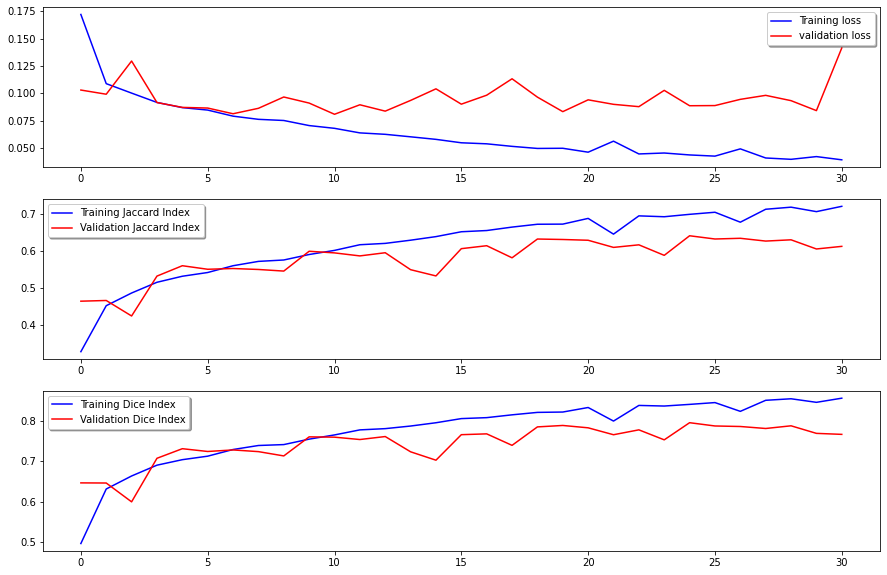

In [ ]:
classifier = Classifier(chip_size=CHIP_SIZE, channels=CHANNELS, 
                        model_dir=MODEL_DIR, labels=LABELS)

classifier.train(input_train=TRAIN_PATH, input_validation=VALIDATION_PATH, 
                epochs=TRAIN_EPOCHS, batch_size=TRAIN_BATCH_SIZE, 
                generator=DataGenerator)

# Evaluate Model

## Run evaluation

In [ ]:
classifier = Classifier(chip_size=CHIP_SIZE,
                        channels=CHANNELS,
                        model_dir=MODEL_DIR,
                        labels=LABELS)

classifier.evaluate(input_test=TEST_PATH)

model = classifier.get_model()
model.save(MODEL_DIR + "/model.h5")

del classifier, model
gc.collect()

Loading model....
Model loaded!
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 4) 0                                            
__________________________________________________________________________________________________
conv2d_19 (Conv2D)              (None, 256, 256, 16) 592         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_18 (BatchNo (None, 256, 256, 16) 64          conv2d_19[0][0]                  
__________________________________________________________________________________________________
activation_18 (Activation)      (None, 256, 256, 16) 0           batch_normalization_18[0][0]     
____________________________________________________________

37005

# Predict Images

In [ ]:
classifier = Classifier(chip_size=PREDICT_CHIP_SIZE,
                        channels=CHANNELS,
                        model_dir=MODEL_DIR,
                        labels=LABELS)

files = [f for f in listdir(PREDICT_INPUT_DIR) if
         isfile(join(PREDICT_INPUT_DIR, f))]

if len(files) == 0:
    print("No file found.")

for f in files:
    print("File:", f)
    input_file = "{directory}/{filepath}".format(directory=PREDICT_INPUT_DIR, filepath=f)

    output_file = "{directory}/{filepath}".format(directory=PREDICT_OUPUT_DIR, filepath=f)

    if not os.path.exists(PREDICT_OUPUT_DIR):
            os.makedirs(PREDICT_OUPUT_DIR)

    if exists(output_file):
        print("File {} exists. Skipping...".format(output_file))
        continue

    print("Predict: ", input_file, "  >>  ", output_file)

    classifier.predict(input_path=input_file, output_path=output_file,
                       grids=PREDICT_GRIDS,
                       batch_size=PREDICT_BATCH_SIZE)

Loading model....
Model loaded!
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 4) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 16) 592         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 16) 64          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 256, 256, 16) 0           batch_normalization[0][0]        
______________________________________________________________

0 windows [00:00, ? windows/s]

dataset loaded


72 windows [00:43,  1.67 windows/s]


Saving results...
Finished!
File: id_95_mosaic.tif
Predict:  /content/drive/MyDrive/TRAIN_LANDSAT_ARROZ/TRAIN LANDSAT ARROZ_train_v5_2015/id_95_mosaic.tif   >>   /content/drive/MyDrive/TRAIN_LANDSAT_ARROZ/TRAIN LANDSAT ARROZ_train_v5_2015/predicted/id_95_mosaic.tif


0 windows [00:00, ? windows/s]

dataset loaded


72 windows [00:10,  7.06 windows/s]


Saving results...
Finished!
File: id_44_mosaic.tif
Predict:  /content/drive/MyDrive/TRAIN_LANDSAT_ARROZ/TRAIN LANDSAT ARROZ_train_v5_2015/id_44_mosaic.tif   >>   /content/drive/MyDrive/TRAIN_LANDSAT_ARROZ/TRAIN LANDSAT ARROZ_train_v5_2015/predicted/id_44_mosaic.tif


0 windows [00:00, ? windows/s]

dataset loaded


72 windows [00:10,  7.19 windows/s]


Saving results...
Finished!
File: id_93_mosaic.tif
Predict:  /content/drive/MyDrive/TRAIN_LANDSAT_ARROZ/TRAIN LANDSAT ARROZ_train_v5_2015/id_93_mosaic.tif   >>   /content/drive/MyDrive/TRAIN_LANDSAT_ARROZ/TRAIN LANDSAT ARROZ_train_v5_2015/predicted/id_93_mosaic.tif


0 windows [00:00, ? windows/s]

dataset loaded


72 windows [00:10,  7.10 windows/s]


Saving results...
Finished!
File: id_144_mosaic.tif
Predict:  /content/drive/MyDrive/TRAIN_LANDSAT_ARROZ/TRAIN LANDSAT ARROZ_train_v5_2015/id_144_mosaic.tif   >>   /content/drive/MyDrive/TRAIN_LANDSAT_ARROZ/TRAIN LANDSAT ARROZ_train_v5_2015/predicted/id_144_mosaic.tif


0 windows [00:00, ? windows/s]

dataset loaded


72 windows [00:10,  6.98 windows/s]


Saving results...
Finished!
File: id_143_mosaic.tif
Predict:  /content/drive/MyDrive/TRAIN_LANDSAT_ARROZ/TRAIN LANDSAT ARROZ_train_v5_2015/id_143_mosaic.tif   >>   /content/drive/MyDrive/TRAIN_LANDSAT_ARROZ/TRAIN LANDSAT ARROZ_train_v5_2015/predicted/id_143_mosaic.tif


0 windows [00:00, ? windows/s]

dataset loaded


72 windows [00:10,  7.12 windows/s]


Saving results...
Finished!
File: id_94_mosaic.tif
Predict:  /content/drive/MyDrive/TRAIN_LANDSAT_ARROZ/TRAIN LANDSAT ARROZ_train_v5_2015/id_94_mosaic.tif   >>   /content/drive/MyDrive/TRAIN_LANDSAT_ARROZ/TRAIN LANDSAT ARROZ_train_v5_2015/predicted/id_94_mosaic.tif


0 windows [00:00, ? windows/s]

dataset loaded


72 windows [00:09,  7.23 windows/s]


Saving results...
Finished!
File: id_145_mosaic.tif
Predict:  /content/drive/MyDrive/TRAIN_LANDSAT_ARROZ/TRAIN LANDSAT ARROZ_train_v5_2015/id_145_mosaic.tif   >>   /content/drive/MyDrive/TRAIN_LANDSAT_ARROZ/TRAIN LANDSAT ARROZ_train_v5_2015/predicted/id_145_mosaic.tif


0 windows [00:00, ? windows/s]

dataset loaded


72 windows [00:10,  6.90 windows/s]


Saving results...
Finished!
File: id_146_mosaic.tif
Predict:  /content/drive/MyDrive/TRAIN_LANDSAT_ARROZ/TRAIN LANDSAT ARROZ_train_v5_2015/id_146_mosaic.tif   >>   /content/drive/MyDrive/TRAIN_LANDSAT_ARROZ/TRAIN LANDSAT ARROZ_train_v5_2015/predicted/id_146_mosaic.tif


0 windows [00:00, ? windows/s]

dataset loaded


72 windows [00:10,  7.03 windows/s]


Saving results...
Finished!
File: id_194_mosaic.tif
Predict:  /content/drive/MyDrive/TRAIN_LANDSAT_ARROZ/TRAIN LANDSAT ARROZ_train_v5_2015/id_194_mosaic.tif   >>   /content/drive/MyDrive/TRAIN_LANDSAT_ARROZ/TRAIN LANDSAT ARROZ_train_v5_2015/predicted/id_194_mosaic.tif


0 windows [00:00, ? windows/s]

dataset loaded


72 windows [00:10,  6.87 windows/s]


Saving results...
Finished!
File: id_195_mosaic.tif
Predict:  /content/drive/MyDrive/TRAIN_LANDSAT_ARROZ/TRAIN LANDSAT ARROZ_train_v5_2015/id_195_mosaic.tif   >>   /content/drive/MyDrive/TRAIN_LANDSAT_ARROZ/TRAIN LANDSAT ARROZ_train_v5_2015/predicted/id_195_mosaic.tif


0 windows [00:00, ? windows/s]

dataset loaded


72 windows [00:10,  7.01 windows/s]


Saving results...
Finished!
File: id_193_mosaic.tif
Predict:  /content/drive/MyDrive/TRAIN_LANDSAT_ARROZ/TRAIN LANDSAT ARROZ_train_v5_2015/id_193_mosaic.tif   >>   /content/drive/MyDrive/TRAIN_LANDSAT_ARROZ/TRAIN LANDSAT ARROZ_train_v5_2015/predicted/id_193_mosaic.tif


0 windows [00:00, ? windows/s]

dataset loaded


72 windows [00:10,  7.01 windows/s]


Saving results...
Finished!
File: id_197_mosaic.tif
Predict:  /content/drive/MyDrive/TRAIN_LANDSAT_ARROZ/TRAIN LANDSAT ARROZ_train_v5_2015/id_197_mosaic.tif   >>   /content/drive/MyDrive/TRAIN_LANDSAT_ARROZ/TRAIN LANDSAT ARROZ_train_v5_2015/predicted/id_197_mosaic.tif


0 windows [00:00, ? windows/s]

dataset loaded


72 windows [00:10,  7.03 windows/s]


Saving results...
Finished!
File: id_196_mosaic.tif
Predict:  /content/drive/MyDrive/TRAIN_LANDSAT_ARROZ/TRAIN LANDSAT ARROZ_train_v5_2015/id_196_mosaic.tif   >>   /content/drive/MyDrive/TRAIN_LANDSAT_ARROZ/TRAIN LANDSAT ARROZ_train_v5_2015/predicted/id_196_mosaic.tif


0 windows [00:00, ? windows/s]

dataset loaded


72 windows [00:10,  7.03 windows/s]


Saving results...
Finished!
File: id_245_mosaic.tif
Predict:  /content/drive/MyDrive/TRAIN_LANDSAT_ARROZ/TRAIN LANDSAT ARROZ_train_v5_2015/id_245_mosaic.tif   >>   /content/drive/MyDrive/TRAIN_LANDSAT_ARROZ/TRAIN LANDSAT ARROZ_train_v5_2015/predicted/id_245_mosaic.tif


0 windows [00:00, ? windows/s]

dataset loaded


72 windows [00:10,  7.00 windows/s]


Saving results...
Finished!
File: id_198_mosaic.tif
Predict:  /content/drive/MyDrive/TRAIN_LANDSAT_ARROZ/TRAIN LANDSAT ARROZ_train_v5_2015/id_198_mosaic.tif   >>   /content/drive/MyDrive/TRAIN_LANDSAT_ARROZ/TRAIN LANDSAT ARROZ_train_v5_2015/predicted/id_198_mosaic.tif


0 windows [00:00, ? windows/s]

dataset loaded


72 windows [00:10,  7.09 windows/s]


Saving results...
Finished!
File: id_244_mosaic.tif
Predict:  /content/drive/MyDrive/TRAIN_LANDSAT_ARROZ/TRAIN LANDSAT ARROZ_train_v5_2015/id_244_mosaic.tif   >>   /content/drive/MyDrive/TRAIN_LANDSAT_ARROZ/TRAIN LANDSAT ARROZ_train_v5_2015/predicted/id_244_mosaic.tif


0 windows [00:00, ? windows/s]

dataset loaded


72 windows [00:10,  7.01 windows/s]


Saving results...
Finished!
File: id_247_mosaic.tif
Predict:  /content/drive/MyDrive/TRAIN_LANDSAT_ARROZ/TRAIN LANDSAT ARROZ_train_v5_2015/id_247_mosaic.tif   >>   /content/drive/MyDrive/TRAIN_LANDSAT_ARROZ/TRAIN LANDSAT ARROZ_train_v5_2015/predicted/id_247_mosaic.tif


0 windows [00:00, ? windows/s]

dataset loaded


72 windows [00:10,  7.08 windows/s]


Saving results...
Finished!
File: id_248_mosaic.tif
Predict:  /content/drive/MyDrive/TRAIN_LANDSAT_ARROZ/TRAIN LANDSAT ARROZ_train_v5_2015/id_248_mosaic.tif   >>   /content/drive/MyDrive/TRAIN_LANDSAT_ARROZ/TRAIN LANDSAT ARROZ_train_v5_2015/predicted/id_248_mosaic.tif


0 windows [00:00, ? windows/s]

dataset loaded


72 windows [00:10,  6.93 windows/s]


Saving results...
Finished!
File: id_246_mosaic.tif
Predict:  /content/drive/MyDrive/TRAIN_LANDSAT_ARROZ/TRAIN LANDSAT ARROZ_train_v5_2015/id_246_mosaic.tif   >>   /content/drive/MyDrive/TRAIN_LANDSAT_ARROZ/TRAIN LANDSAT ARROZ_train_v5_2015/predicted/id_246_mosaic.tif


0 windows [00:00, ? windows/s]

dataset loaded


72 windows [00:10,  7.04 windows/s]


Saving results...
Finished!
File: id_298_mosaic.tif
Predict:  /content/drive/MyDrive/TRAIN_LANDSAT_ARROZ/TRAIN LANDSAT ARROZ_train_v5_2015/id_298_mosaic.tif   >>   /content/drive/MyDrive/TRAIN_LANDSAT_ARROZ/TRAIN LANDSAT ARROZ_train_v5_2015/predicted/id_298_mosaic.tif


0 windows [00:00, ? windows/s]

dataset loaded


72 windows [00:10,  6.97 windows/s]


Saving results...
Finished!
File: id_250_mosaic.tif
Predict:  /content/drive/MyDrive/TRAIN_LANDSAT_ARROZ/TRAIN LANDSAT ARROZ_train_v5_2015/id_250_mosaic.tif   >>   /content/drive/MyDrive/TRAIN_LANDSAT_ARROZ/TRAIN LANDSAT ARROZ_train_v5_2015/predicted/id_250_mosaic.tif


0 windows [00:00, ? windows/s]

dataset loaded


72 windows [00:10,  6.89 windows/s]


Saving results...
Finished!
File: id_297_mosaic.tif
Predict:  /content/drive/MyDrive/TRAIN_LANDSAT_ARROZ/TRAIN LANDSAT ARROZ_train_v5_2015/id_297_mosaic.tif   >>   /content/drive/MyDrive/TRAIN_LANDSAT_ARROZ/TRAIN LANDSAT ARROZ_train_v5_2015/predicted/id_297_mosaic.tif


0 windows [00:00, ? windows/s]

dataset loaded


72 windows [00:10,  7.04 windows/s]


Saving results...
Finished!
File: id_299_mosaic.tif
Predict:  /content/drive/MyDrive/TRAIN_LANDSAT_ARROZ/TRAIN LANDSAT ARROZ_train_v5_2015/id_299_mosaic.tif   >>   /content/drive/MyDrive/TRAIN_LANDSAT_ARROZ/TRAIN LANDSAT ARROZ_train_v5_2015/predicted/id_299_mosaic.tif


0 windows [00:00, ? windows/s]

dataset loaded


72 windows [00:10,  6.90 windows/s]


Saving results...
Finished!
File: id_249_mosaic.tif
Predict:  /content/drive/MyDrive/TRAIN_LANDSAT_ARROZ/TRAIN LANDSAT ARROZ_train_v5_2015/id_249_mosaic.tif   >>   /content/drive/MyDrive/TRAIN_LANDSAT_ARROZ/TRAIN LANDSAT ARROZ_train_v5_2015/predicted/id_249_mosaic.tif


0 windows [00:00, ? windows/s]

dataset loaded


72 windows [00:10,  7.00 windows/s]


Saving results...
Finished!
File: id_300_mosaic.tif
Predict:  /content/drive/MyDrive/TRAIN_LANDSAT_ARROZ/TRAIN LANDSAT ARROZ_train_v5_2015/id_300_mosaic.tif   >>   /content/drive/MyDrive/TRAIN_LANDSAT_ARROZ/TRAIN LANDSAT ARROZ_train_v5_2015/predicted/id_300_mosaic.tif


0 windows [00:00, ? windows/s]

dataset loaded


72 windows [00:10,  7.04 windows/s]


Saving results...
Finished!
File: id_301_mosaic.tif
Predict:  /content/drive/MyDrive/TRAIN_LANDSAT_ARROZ/TRAIN LANDSAT ARROZ_train_v5_2015/id_301_mosaic.tif   >>   /content/drive/MyDrive/TRAIN_LANDSAT_ARROZ/TRAIN LANDSAT ARROZ_train_v5_2015/predicted/id_301_mosaic.tif


0 windows [00:00, ? windows/s]

dataset loaded


72 windows [00:10,  7.00 windows/s]


Saving results...
Finished!
File: id_349_mosaic.tif
Predict:  /content/drive/MyDrive/TRAIN_LANDSAT_ARROZ/TRAIN LANDSAT ARROZ_train_v5_2015/id_349_mosaic.tif   >>   /content/drive/MyDrive/TRAIN_LANDSAT_ARROZ/TRAIN LANDSAT ARROZ_train_v5_2015/predicted/id_349_mosaic.tif


0 windows [00:00, ? windows/s]

dataset loaded


72 windows [00:10,  6.96 windows/s]


Saving results...
Finished!
File: id_348_mosaic.tif
Predict:  /content/drive/MyDrive/TRAIN_LANDSAT_ARROZ/TRAIN LANDSAT ARROZ_train_v5_2015/id_348_mosaic.tif   >>   /content/drive/MyDrive/TRAIN_LANDSAT_ARROZ/TRAIN LANDSAT ARROZ_train_v5_2015/predicted/id_348_mosaic.tif


0 windows [00:00, ? windows/s]

dataset loaded


72 windows [00:10,  7.03 windows/s]


Saving results...
Finished!
File: id_350_mosaic.tif
Predict:  /content/drive/MyDrive/TRAIN_LANDSAT_ARROZ/TRAIN LANDSAT ARROZ_train_v5_2015/id_350_mosaic.tif   >>   /content/drive/MyDrive/TRAIN_LANDSAT_ARROZ/TRAIN LANDSAT ARROZ_train_v5_2015/predicted/id_350_mosaic.tif


0 windows [00:00, ? windows/s]

dataset loaded


72 windows [00:10,  6.95 windows/s]


Saving results...
Finished!
File: id_351_mosaic.tif
Predict:  /content/drive/MyDrive/TRAIN_LANDSAT_ARROZ/TRAIN LANDSAT ARROZ_train_v5_2015/id_351_mosaic.tif   >>   /content/drive/MyDrive/TRAIN_LANDSAT_ARROZ/TRAIN LANDSAT ARROZ_train_v5_2015/predicted/id_351_mosaic.tif


0 windows [00:00, ? windows/s]

dataset loaded


72 windows [00:10,  6.94 windows/s]


Saving results...
Finished!
File: id_399_mosaic.tif
Predict:  /content/drive/MyDrive/TRAIN_LANDSAT_ARROZ/TRAIN LANDSAT ARROZ_train_v5_2015/id_399_mosaic.tif   >>   /content/drive/MyDrive/TRAIN_LANDSAT_ARROZ/TRAIN LANDSAT ARROZ_train_v5_2015/predicted/id_399_mosaic.tif


0 windows [00:00, ? windows/s]

dataset loaded


72 windows [00:10,  7.12 windows/s]


Saving results...
Finished!
File: id_352_mosaic.tif
Predict:  /content/drive/MyDrive/TRAIN_LANDSAT_ARROZ/TRAIN LANDSAT ARROZ_train_v5_2015/id_352_mosaic.tif   >>   /content/drive/MyDrive/TRAIN_LANDSAT_ARROZ/TRAIN LANDSAT ARROZ_train_v5_2015/predicted/id_352_mosaic.tif


0 windows [00:00, ? windows/s]

dataset loaded


72 windows [00:10,  7.08 windows/s]


Saving results...
Finished!
File: id_353_mosaic.tif
Predict:  /content/drive/MyDrive/TRAIN_LANDSAT_ARROZ/TRAIN LANDSAT ARROZ_train_v5_2015/id_353_mosaic.tif   >>   /content/drive/MyDrive/TRAIN_LANDSAT_ARROZ/TRAIN LANDSAT ARROZ_train_v5_2015/predicted/id_353_mosaic.tif


0 windows [00:00, ? windows/s]

dataset loaded


72 windows [00:10,  7.14 windows/s]


Saving results...
Finished!
File: id_400_mosaic.tif
Predict:  /content/drive/MyDrive/TRAIN_LANDSAT_ARROZ/TRAIN LANDSAT ARROZ_train_v5_2015/id_400_mosaic.tif   >>   /content/drive/MyDrive/TRAIN_LANDSAT_ARROZ/TRAIN LANDSAT ARROZ_train_v5_2015/predicted/id_400_mosaic.tif


0 windows [00:00, ? windows/s]

dataset loaded


72 windows [00:10,  7.08 windows/s]


Saving results...
Finished!
File: id_402_mosaic.tif
Predict:  /content/drive/MyDrive/TRAIN_LANDSAT_ARROZ/TRAIN LANDSAT ARROZ_train_v5_2015/id_402_mosaic.tif   >>   /content/drive/MyDrive/TRAIN_LANDSAT_ARROZ/TRAIN LANDSAT ARROZ_train_v5_2015/predicted/id_402_mosaic.tif


0 windows [00:00, ? windows/s]

dataset loaded


72 windows [00:10,  7.04 windows/s]


Saving results...
Finished!
File: id_403_mosaic.tif
Predict:  /content/drive/MyDrive/TRAIN_LANDSAT_ARROZ/TRAIN LANDSAT ARROZ_train_v5_2015/id_403_mosaic.tif   >>   /content/drive/MyDrive/TRAIN_LANDSAT_ARROZ/TRAIN LANDSAT ARROZ_train_v5_2015/predicted/id_403_mosaic.tif


0 windows [00:00, ? windows/s]

dataset loaded


72 windows [00:10,  7.00 windows/s]


Saving results...
Finished!
File: id_404_mosaic.tif
Predict:  /content/drive/MyDrive/TRAIN_LANDSAT_ARROZ/TRAIN LANDSAT ARROZ_train_v5_2015/id_404_mosaic.tif   >>   /content/drive/MyDrive/TRAIN_LANDSAT_ARROZ/TRAIN LANDSAT ARROZ_train_v5_2015/predicted/id_404_mosaic.tif


0 windows [00:00, ? windows/s]

dataset loaded


72 windows [00:10,  7.05 windows/s]


Saving results...
Finished!
File: id_401_mosaic.tif
Predict:  /content/drive/MyDrive/TRAIN_LANDSAT_ARROZ/TRAIN LANDSAT ARROZ_train_v5_2015/id_401_mosaic.tif   >>   /content/drive/MyDrive/TRAIN_LANDSAT_ARROZ/TRAIN LANDSAT ARROZ_train_v5_2015/predicted/id_401_mosaic.tif


0 windows [00:00, ? windows/s]

dataset loaded


72 windows [00:10,  7.11 windows/s]


Saving results...
Finished!
File: id_405_mosaic.tif
Predict:  /content/drive/MyDrive/TRAIN_LANDSAT_ARROZ/TRAIN LANDSAT ARROZ_train_v5_2015/id_405_mosaic.tif   >>   /content/drive/MyDrive/TRAIN_LANDSAT_ARROZ/TRAIN LANDSAT ARROZ_train_v5_2015/predicted/id_405_mosaic.tif


0 windows [00:00, ? windows/s]

dataset loaded


72 windows [00:10,  7.13 windows/s]


Saving results...
Finished!
File: id_450_mosaic.tif
Predict:  /content/drive/MyDrive/TRAIN_LANDSAT_ARROZ/TRAIN LANDSAT ARROZ_train_v5_2015/id_450_mosaic.tif   >>   /content/drive/MyDrive/TRAIN_LANDSAT_ARROZ/TRAIN LANDSAT ARROZ_train_v5_2015/predicted/id_450_mosaic.tif


0 windows [00:00, ? windows/s]

dataset loaded


72 windows [00:10,  7.05 windows/s]


Saving results...
Finished!
File: id_452_mosaic.tif
Predict:  /content/drive/MyDrive/TRAIN_LANDSAT_ARROZ/TRAIN LANDSAT ARROZ_train_v5_2015/id_452_mosaic.tif   >>   /content/drive/MyDrive/TRAIN_LANDSAT_ARROZ/TRAIN LANDSAT ARROZ_train_v5_2015/predicted/id_452_mosaic.tif


0 windows [00:00, ? windows/s]

dataset loaded


72 windows [00:10,  7.05 windows/s]


Saving results...
Finished!
File: id_451_mosaic.tif
Predict:  /content/drive/MyDrive/TRAIN_LANDSAT_ARROZ/TRAIN LANDSAT ARROZ_train_v5_2015/id_451_mosaic.tif   >>   /content/drive/MyDrive/TRAIN_LANDSAT_ARROZ/TRAIN LANDSAT ARROZ_train_v5_2015/predicted/id_451_mosaic.tif


0 windows [00:00, ? windows/s]

dataset loaded


72 windows [00:10,  7.09 windows/s]


Saving results...
Finished!
File: id_456_mosaic.tif
Predict:  /content/drive/MyDrive/TRAIN_LANDSAT_ARROZ/TRAIN LANDSAT ARROZ_train_v5_2015/id_456_mosaic.tif   >>   /content/drive/MyDrive/TRAIN_LANDSAT_ARROZ/TRAIN LANDSAT ARROZ_train_v5_2015/predicted/id_456_mosaic.tif


0 windows [00:00, ? windows/s]

dataset loaded


72 windows [00:10,  7.04 windows/s]


Saving results...
Finished!
File: id_453_mosaic.tif
Predict:  /content/drive/MyDrive/TRAIN_LANDSAT_ARROZ/TRAIN LANDSAT ARROZ_train_v5_2015/id_453_mosaic.tif   >>   /content/drive/MyDrive/TRAIN_LANDSAT_ARROZ/TRAIN LANDSAT ARROZ_train_v5_2015/predicted/id_453_mosaic.tif


0 windows [00:00, ? windows/s]

dataset loaded


72 windows [00:10,  7.04 windows/s]


Saving results...
Finished!
File: id_457_mosaic.tif
Predict:  /content/drive/MyDrive/TRAIN_LANDSAT_ARROZ/TRAIN LANDSAT ARROZ_train_v5_2015/id_457_mosaic.tif   >>   /content/drive/MyDrive/TRAIN_LANDSAT_ARROZ/TRAIN LANDSAT ARROZ_train_v5_2015/predicted/id_457_mosaic.tif


0 windows [00:00, ? windows/s]

dataset loaded


72 windows [00:10,  7.08 windows/s]


Saving results...
Finished!
File: id_458_mosaic.tif
Predict:  /content/drive/MyDrive/TRAIN_LANDSAT_ARROZ/TRAIN LANDSAT ARROZ_train_v5_2015/id_458_mosaic.tif   >>   /content/drive/MyDrive/TRAIN_LANDSAT_ARROZ/TRAIN LANDSAT ARROZ_train_v5_2015/predicted/id_458_mosaic.tif


0 windows [00:00, ? windows/s]

dataset loaded


72 windows [00:10,  7.04 windows/s]


Saving results...
Finished!
File: id_459_mosaic.tif
Predict:  /content/drive/MyDrive/TRAIN_LANDSAT_ARROZ/TRAIN LANDSAT ARROZ_train_v5_2015/id_459_mosaic.tif   >>   /content/drive/MyDrive/TRAIN_LANDSAT_ARROZ/TRAIN LANDSAT ARROZ_train_v5_2015/predicted/id_459_mosaic.tif


0 windows [00:00, ? windows/s]

dataset loaded


72 windows [00:10,  7.01 windows/s]


Saving results...
Finished!
File: id_502_mosaic.tif
Predict:  /content/drive/MyDrive/TRAIN_LANDSAT_ARROZ/TRAIN LANDSAT ARROZ_train_v5_2015/id_502_mosaic.tif   >>   /content/drive/MyDrive/TRAIN_LANDSAT_ARROZ/TRAIN LANDSAT ARROZ_train_v5_2015/predicted/id_502_mosaic.tif


0 windows [00:00, ? windows/s]

dataset loaded


72 windows [00:10,  6.94 windows/s]


Saving results...
Finished!
File: id_504_mosaic.tif
Predict:  /content/drive/MyDrive/TRAIN_LANDSAT_ARROZ/TRAIN LANDSAT ARROZ_train_v5_2015/id_504_mosaic.tif   >>   /content/drive/MyDrive/TRAIN_LANDSAT_ARROZ/TRAIN LANDSAT ARROZ_train_v5_2015/predicted/id_504_mosaic.tif


0 windows [00:00, ? windows/s]

dataset loaded


72 windows [00:10,  6.97 windows/s]


Saving results...
Finished!
File: id_503_mosaic.tif
Predict:  /content/drive/MyDrive/TRAIN_LANDSAT_ARROZ/TRAIN LANDSAT ARROZ_train_v5_2015/id_503_mosaic.tif   >>   /content/drive/MyDrive/TRAIN_LANDSAT_ARROZ/TRAIN LANDSAT ARROZ_train_v5_2015/predicted/id_503_mosaic.tif


0 windows [00:00, ? windows/s]

dataset loaded


72 windows [00:10,  6.63 windows/s]


Saving results...
Finished!
File: id_508_mosaic.tif
Predict:  /content/drive/MyDrive/TRAIN_LANDSAT_ARROZ/TRAIN LANDSAT ARROZ_train_v5_2015/id_508_mosaic.tif   >>   /content/drive/MyDrive/TRAIN_LANDSAT_ARROZ/TRAIN LANDSAT ARROZ_train_v5_2015/predicted/id_508_mosaic.tif


0 windows [00:00, ? windows/s]

dataset loaded


72 windows [00:10,  6.79 windows/s]


Saving results...
Finished!
File: id_507_mosaic.tif
Predict:  /content/drive/MyDrive/TRAIN_LANDSAT_ARROZ/TRAIN LANDSAT ARROZ_train_v5_2015/id_507_mosaic.tif   >>   /content/drive/MyDrive/TRAIN_LANDSAT_ARROZ/TRAIN LANDSAT ARROZ_train_v5_2015/predicted/id_507_mosaic.tif


0 windows [00:00, ? windows/s]

dataset loaded


72 windows [00:10,  6.67 windows/s]


Saving results...
Finished!
File: id_506_mosaic.tif
Predict:  /content/drive/MyDrive/TRAIN_LANDSAT_ARROZ/TRAIN LANDSAT ARROZ_train_v5_2015/id_506_mosaic.tif   >>   /content/drive/MyDrive/TRAIN_LANDSAT_ARROZ/TRAIN LANDSAT ARROZ_train_v5_2015/predicted/id_506_mosaic.tif


0 windows [00:00, ? windows/s]

dataset loaded


72 windows [00:10,  6.75 windows/s]


Saving results...
Finished!
File: id_509_mosaic.tif
Predict:  /content/drive/MyDrive/TRAIN_LANDSAT_ARROZ/TRAIN LANDSAT ARROZ_train_v5_2015/id_509_mosaic.tif   >>   /content/drive/MyDrive/TRAIN_LANDSAT_ARROZ/TRAIN LANDSAT ARROZ_train_v5_2015/predicted/id_509_mosaic.tif


0 windows [00:00, ? windows/s]

dataset loaded


72 windows [00:10,  6.92 windows/s]


Saving results...
Finished!
File: id_554_mosaic.tif
Predict:  /content/drive/MyDrive/TRAIN_LANDSAT_ARROZ/TRAIN LANDSAT ARROZ_train_v5_2015/id_554_mosaic.tif   >>   /content/drive/MyDrive/TRAIN_LANDSAT_ARROZ/TRAIN LANDSAT ARROZ_train_v5_2015/predicted/id_554_mosaic.tif


0 windows [00:00, ? windows/s]

dataset loaded


72 windows [00:10,  6.98 windows/s]


Saving results...
Finished!
File: id_555_mosaic.tif
Predict:  /content/drive/MyDrive/TRAIN_LANDSAT_ARROZ/TRAIN LANDSAT ARROZ_train_v5_2015/id_555_mosaic.tif   >>   /content/drive/MyDrive/TRAIN_LANDSAT_ARROZ/TRAIN LANDSAT ARROZ_train_v5_2015/predicted/id_555_mosaic.tif


0 windows [00:00, ? windows/s]

dataset loaded


72 windows [00:10,  7.00 windows/s]


Saving results...
Finished!
File: id_553_mosaic.tif
Predict:  /content/drive/MyDrive/TRAIN_LANDSAT_ARROZ/TRAIN LANDSAT ARROZ_train_v5_2015/id_553_mosaic.tif   >>   /content/drive/MyDrive/TRAIN_LANDSAT_ARROZ/TRAIN LANDSAT ARROZ_train_v5_2015/predicted/id_553_mosaic.tif


0 windows [00:00, ? windows/s]

dataset loaded


72 windows [00:10,  7.00 windows/s]


Saving results...
Finished!
File: id_557_mosaic.tif
Predict:  /content/drive/MyDrive/TRAIN_LANDSAT_ARROZ/TRAIN LANDSAT ARROZ_train_v5_2015/id_557_mosaic.tif   >>   /content/drive/MyDrive/TRAIN_LANDSAT_ARROZ/TRAIN LANDSAT ARROZ_train_v5_2015/predicted/id_557_mosaic.tif


0 windows [00:00, ? windows/s]

dataset loaded


72 windows [00:10,  6.94 windows/s]


Saving results...
Finished!
File: id_556_mosaic.tif
Predict:  /content/drive/MyDrive/TRAIN_LANDSAT_ARROZ/TRAIN LANDSAT ARROZ_train_v5_2015/id_556_mosaic.tif   >>   /content/drive/MyDrive/TRAIN_LANDSAT_ARROZ/TRAIN LANDSAT ARROZ_train_v5_2015/predicted/id_556_mosaic.tif


0 windows [00:00, ? windows/s]

dataset loaded


72 windows [00:10,  7.07 windows/s]


Saving results...
Finished!
File: id_605_mosaic.tif
Predict:  /content/drive/MyDrive/TRAIN_LANDSAT_ARROZ/TRAIN LANDSAT ARROZ_train_v5_2015/id_605_mosaic.tif   >>   /content/drive/MyDrive/TRAIN_LANDSAT_ARROZ/TRAIN LANDSAT ARROZ_train_v5_2015/predicted/id_605_mosaic.tif


0 windows [00:00, ? windows/s]

dataset loaded


72 windows [00:10,  7.02 windows/s]


Saving results...
Finished!
File: id_558_mosaic.tif
Predict:  /content/drive/MyDrive/TRAIN_LANDSAT_ARROZ/TRAIN LANDSAT ARROZ_train_v5_2015/id_558_mosaic.tif   >>   /content/drive/MyDrive/TRAIN_LANDSAT_ARROZ/TRAIN LANDSAT ARROZ_train_v5_2015/predicted/id_558_mosaic.tif


0 windows [00:00, ? windows/s]

dataset loaded


72 windows [00:10,  6.96 windows/s]


Saving results...
Finished!
File: id_604_mosaic.tif
Predict:  /content/drive/MyDrive/TRAIN_LANDSAT_ARROZ/TRAIN LANDSAT ARROZ_train_v5_2015/id_604_mosaic.tif   >>   /content/drive/MyDrive/TRAIN_LANDSAT_ARROZ/TRAIN LANDSAT ARROZ_train_v5_2015/predicted/id_604_mosaic.tif


0 windows [00:00, ? windows/s]

dataset loaded


72 windows [00:10,  7.03 windows/s]


Saving results...
Finished!
File: id_606_mosaic.tif
Predict:  /content/drive/MyDrive/TRAIN_LANDSAT_ARROZ/TRAIN LANDSAT ARROZ_train_v5_2015/id_606_mosaic.tif   >>   /content/drive/MyDrive/TRAIN_LANDSAT_ARROZ/TRAIN LANDSAT ARROZ_train_v5_2015/predicted/id_606_mosaic.tif


0 windows [00:00, ? windows/s]

dataset loaded


72 windows [00:10,  7.03 windows/s]


Saving results...
Finished!
File: id_655_mosaic.tif
Predict:  /content/drive/MyDrive/TRAIN_LANDSAT_ARROZ/TRAIN LANDSAT ARROZ_train_v5_2015/id_655_mosaic.tif   >>   /content/drive/MyDrive/TRAIN_LANDSAT_ARROZ/TRAIN LANDSAT ARROZ_train_v5_2015/predicted/id_655_mosaic.tif


0 windows [00:00, ? windows/s]

dataset loaded


72 windows [00:10,  7.05 windows/s]


Saving results...
Finished!
File: id_607_mosaic.tif
Predict:  /content/drive/MyDrive/TRAIN_LANDSAT_ARROZ/TRAIN LANDSAT ARROZ_train_v5_2015/id_607_mosaic.tif   >>   /content/drive/MyDrive/TRAIN_LANDSAT_ARROZ/TRAIN LANDSAT ARROZ_train_v5_2015/predicted/id_607_mosaic.tif


0 windows [00:00, ? windows/s]

dataset loaded


72 windows [00:10,  7.00 windows/s]


Saving results...
Finished!
File: id_657_mosaic.tif
Predict:  /content/drive/MyDrive/TRAIN_LANDSAT_ARROZ/TRAIN LANDSAT ARROZ_train_v5_2015/id_657_mosaic.tif   >>   /content/drive/MyDrive/TRAIN_LANDSAT_ARROZ/TRAIN LANDSAT ARROZ_train_v5_2015/predicted/id_657_mosaic.tif


0 windows [00:00, ? windows/s]

dataset loaded


72 windows [00:10,  7.07 windows/s]


Saving results...
Finished!
File: id_608_mosaic.tif
Predict:  /content/drive/MyDrive/TRAIN_LANDSAT_ARROZ/TRAIN LANDSAT ARROZ_train_v5_2015/id_608_mosaic.tif   >>   /content/drive/MyDrive/TRAIN_LANDSAT_ARROZ/TRAIN LANDSAT ARROZ_train_v5_2015/predicted/id_608_mosaic.tif


0 windows [00:00, ? windows/s]

dataset loaded


72 windows [00:10,  7.01 windows/s]


Saving results...
Finished!
File: id_658_mosaic.tif
Predict:  /content/drive/MyDrive/TRAIN_LANDSAT_ARROZ/TRAIN LANDSAT ARROZ_train_v5_2015/id_658_mosaic.tif   >>   /content/drive/MyDrive/TRAIN_LANDSAT_ARROZ/TRAIN LANDSAT ARROZ_train_v5_2015/predicted/id_658_mosaic.tif


0 windows [00:00, ? windows/s]

dataset loaded


72 windows [00:10,  6.89 windows/s]


Saving results...
Finished!
File: id_659_mosaic.tif
Predict:  /content/drive/MyDrive/TRAIN_LANDSAT_ARROZ/TRAIN LANDSAT ARROZ_train_v5_2015/id_659_mosaic.tif   >>   /content/drive/MyDrive/TRAIN_LANDSAT_ARROZ/TRAIN LANDSAT ARROZ_train_v5_2015/predicted/id_659_mosaic.tif


0 windows [00:00, ? windows/s]

dataset loaded


72 windows [00:10,  6.97 windows/s]


Saving results...
Finished!
File: id_656_mosaic.tif
Predict:  /content/drive/MyDrive/TRAIN_LANDSAT_ARROZ/TRAIN LANDSAT ARROZ_train_v5_2015/id_656_mosaic.tif   >>   /content/drive/MyDrive/TRAIN_LANDSAT_ARROZ/TRAIN LANDSAT ARROZ_train_v5_2015/predicted/id_656_mosaic.tif


0 windows [00:00, ? windows/s]

dataset loaded


72 windows [00:10,  6.82 windows/s]


Saving results...
Finished!
File: id_707_mosaic.tif
Predict:  /content/drive/MyDrive/TRAIN_LANDSAT_ARROZ/TRAIN LANDSAT ARROZ_train_v5_2015/id_707_mosaic.tif   >>   /content/drive/MyDrive/TRAIN_LANDSAT_ARROZ/TRAIN LANDSAT ARROZ_train_v5_2015/predicted/id_707_mosaic.tif


0 windows [00:00, ? windows/s]

dataset loaded


72 windows [00:10,  6.87 windows/s]


Saving results...
Finished!
File: id_706_mosaic.tif
Predict:  /content/drive/MyDrive/TRAIN_LANDSAT_ARROZ/TRAIN LANDSAT ARROZ_train_v5_2015/id_706_mosaic.tif   >>   /content/drive/MyDrive/TRAIN_LANDSAT_ARROZ/TRAIN LANDSAT ARROZ_train_v5_2015/predicted/id_706_mosaic.tif


0 windows [00:00, ? windows/s]

dataset loaded


72 windows [00:10,  6.85 windows/s]


Saving results...
Finished!
File: id_709_mosaic.tif
Predict:  /content/drive/MyDrive/TRAIN_LANDSAT_ARROZ/TRAIN LANDSAT ARROZ_train_v5_2015/id_709_mosaic.tif   >>   /content/drive/MyDrive/TRAIN_LANDSAT_ARROZ/TRAIN LANDSAT ARROZ_train_v5_2015/predicted/id_709_mosaic.tif


0 windows [00:00, ? windows/s]

dataset loaded


72 windows [00:10,  6.93 windows/s]


Saving results...
Finished!
File: id_757_mosaic.tif
Predict:  /content/drive/MyDrive/TRAIN_LANDSAT_ARROZ/TRAIN LANDSAT ARROZ_train_v5_2015/id_757_mosaic.tif   >>   /content/drive/MyDrive/TRAIN_LANDSAT_ARROZ/TRAIN LANDSAT ARROZ_train_v5_2015/predicted/id_757_mosaic.tif


0 windows [00:00, ? windows/s]

dataset loaded


72 windows [00:10,  7.00 windows/s]


Saving results...
Finished!
File: id_758_mosaic.tif
Predict:  /content/drive/MyDrive/TRAIN_LANDSAT_ARROZ/TRAIN LANDSAT ARROZ_train_v5_2015/id_758_mosaic.tif   >>   /content/drive/MyDrive/TRAIN_LANDSAT_ARROZ/TRAIN LANDSAT ARROZ_train_v5_2015/predicted/id_758_mosaic.tif


0 windows [00:00, ? windows/s]

dataset loaded


72 windows [00:10,  6.89 windows/s]


Saving results...
Finished!
File: id_808_mosaic.tif
Predict:  /content/drive/MyDrive/TRAIN_LANDSAT_ARROZ/TRAIN LANDSAT ARROZ_train_v5_2015/id_808_mosaic.tif   >>   /content/drive/MyDrive/TRAIN_LANDSAT_ARROZ/TRAIN LANDSAT ARROZ_train_v5_2015/predicted/id_808_mosaic.tif


0 windows [00:00, ? windows/s]

dataset loaded


72 windows [00:10,  6.90 windows/s]


Saving results...
Finished!
File: id_708_mosaic.tif
Predict:  /content/drive/MyDrive/TRAIN_LANDSAT_ARROZ/TRAIN LANDSAT ARROZ_train_v5_2015/id_708_mosaic.tif   >>   /content/drive/MyDrive/TRAIN_LANDSAT_ARROZ/TRAIN LANDSAT ARROZ_train_v5_2015/predicted/id_708_mosaic.tif


0 windows [00:00, ? windows/s]

dataset loaded


72 windows [00:10,  6.87 windows/s]


Saving results...
Finished!
File: id_759_mosaic.tif
Predict:  /content/drive/MyDrive/TRAIN_LANDSAT_ARROZ/TRAIN LANDSAT ARROZ_train_v5_2015/id_759_mosaic.tif   >>   /content/drive/MyDrive/TRAIN_LANDSAT_ARROZ/TRAIN LANDSAT ARROZ_train_v5_2015/predicted/id_759_mosaic.tif


0 windows [00:00, ? windows/s]

dataset loaded


72 windows [00:10,  6.83 windows/s]


Saving results...
Finished!
